In [ ]:
import gc
import numpy as np
import pandas as pd
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
)

from imblearn.over_sampling import RandomOverSampler
import evaluate
from datasets import ClassLabel, Dataset

from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
)
import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomRotation,
    RandomAdjustSharpness,
    Resize,
    ToTensor,
)

from PIL import ImageFile, Image
import warnings

warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
image_dict = {}

# Define the list of file names
file_names = []
labels = []

for file in sorted(
    (Path("cifake-real-and-ai-generated-synthetic-images/").glob("*/*/*.*"))
):
    label = str(file).split("/")[-2]
    labels.append(label)
    file_names.append(str(file))
print(len(file_names), len(labels))

df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

120000 120000
(120000, 2)


In [ ]:
y = df[["label"]]
df = df.drop(["label"], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
df["label"] = y_resampled
gc.collect()

print(df.shape)

(120000, 2)


In [ ]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = ['REAL', 'FAKE']

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'REAL', 1: 'FAKE'} 

Mapping of Labels to IDs: {'REAL': 0, 'FAKE': 1}


In [ ]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = Dataset.from_pandas(df).cast_column("image", Image())
dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset['train']
test_data = dataset['test']

In [ ]:
model_str = "google/vit-base-patch16-224-in21k"

processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        ToTensor(),
        normalize,
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        normalize,
    ]
)


# Function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples["pixel_values"] = [
        _train_transforms(image.convert("RGB")) for image in examples["image"]
    ]
    return examples


# Function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples["pixel_values"] = [
        _val_transforms(image.convert("RGB")) for image in examples["image"]
    ]
    return examples

In [ ]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [ ]:
# Collate function that prepares batched data for model training.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

In [ ]:
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = eval_pred.predictions

    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)[
        "accuracy"
    ]

    return {"accuracy": acc_score}

In [ ]:
metric_name = "accuracy"

model_name = "ai_vs_real_image_detection"
num_train_epochs = 2

# Instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    output_dir=model_name,
    logging_dir="./logs",
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none",
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

# Start training the model using the trainer object.
trainer.train()

In [ ]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.04815581813454628, 'test_accuracy': 0.9825, 'test_runtime': 676.7385, 'test_samples_per_second': 70.928, 'test_steps_per_second': 2.217}


Accuracy: 0.9825
F1 Score: 0.9825


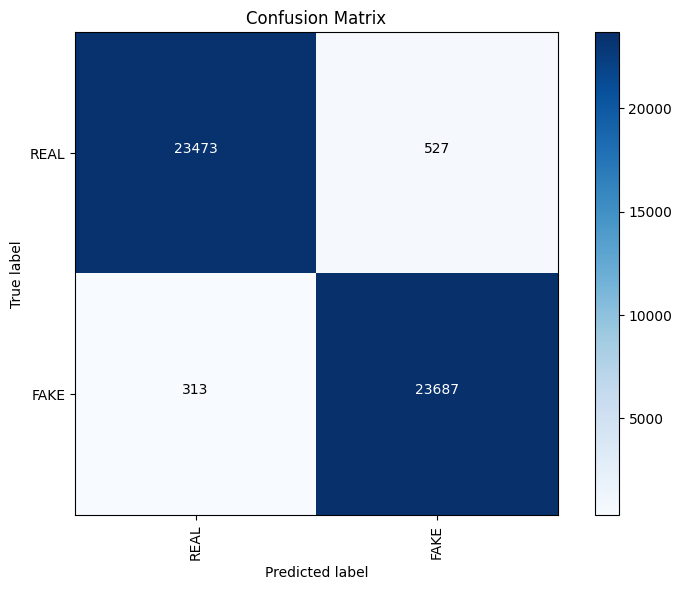


Classification report:

              precision    recall  f1-score   support

        REAL     0.9868    0.9780    0.9824     24000
        FAKE     0.9782    0.9870    0.9826     24000

    accuracy                         0.9825     48000
   macro avg     0.9825    0.9825    0.9825     48000
weighted avg     0.9825    0.9825    0.9825     48000



In [ ]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)


# Function to plot a confusion matrix
def plot_confusion_matrix(
    cm, classes, title="Confusion Matrix", cmap=plt.cm.Blues, figsize=(10, 8)
):
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".0f"
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    plt.tight_layout()
    plt.show()


# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [ ]:
trainer.save_model()